# AG News Dataset

In [1]:
import sys
sys.path.append('../')
import torch
import numpy as np
from matplotlib import pyplot as plt

In [2]:
from model import Model
from dataset_class import AGNewsDataset
from evaluation import EvaluationClassification
import acquisition
import estimators
import metrics
import utils
import visualize

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
prompt = """To which category does the following news article belong: "world", "sports", "business", or "science and technology"?\n"""

In [4]:
dataset_file = 'agnews'

## LLaMa2 70B

In [6]:
model_file = 'llama2_70b'

In [ ]:
llama = Model(model_name="Llama-2-70b",
                    model_file=model_file,
                    dataset_file=dataset_file,
                    prompt=prompt,
                    device=device)

In [ ]:
agnews_dataset = AGNewsDataset(dataset_file=dataset_file)
agnews_dataset.load(prompt=llama.prompt,
                        tokenizer=llama.model.tokenizer, 
                        device=device)

In [ ]:
llama_evaluation = EvaluationClassification(llama,
                                            agnews_dataset,
                                            device)

In [ ]:
llama_evaluation.evaluation_procedure('full', batch_size=5, save=True)

In [10]:
llama_evaluation.evaluation_procedure('active', batch_size=5, save=True)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [46:36<00:00,  1.40s/it]

Accuracy: 0.7538999915122986 - Loss: 0.7104683518409729


In [ ]:
llama_evaluation.evaluation_icl_procedure('active', batch_size=1, nb_icl_examples=40, save=True)

## Llama2 7B

In [ ]:
model_file = 'llama2_7b'

In [ ]:
llama = Model(model_name="Llama-2-7b-8bit",
            model_file=model_file,
            dataset_file=dataset_file,
            prompt=prompt,
            device=device)

In [ ]:
agnews_dataset = AGNewsDataset(dataset_file=dataset_file)
agnews_dataset.load(prompt=llama.prompt,
                    tokenizer=llama.model.tokenizer, 
                    device=device)

In [8]:
llama_evaluation = EvaluationClassification(llama,
                                            agnews_dataset,
                                            device)

In [9]:
llama_evaluation.evaluation_lhs_procedure('active', batch_size=30, save=True)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 334/334 [07:16<00:00,  1.31s/it]


In [10]:
llama_evaluation.evaluation_procedure('full', batch_size=20, save=True)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [06:55<00:00,  1.20it/s]

Accuracy: 0.7063000202178955 - Loss: 0.8825948238372803


In [9]:
llama_evaluation.evaluation_icl_procedure('active', nb_icl_examples=40, batch_size=1, save=True, version=1)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [1:51:07<00:00,  1.50it/s]

Accuracy: 0.8668000102043152 - Loss: 0.3712097704410553


## Acquisition

In [5]:
STEP = 1
RUNS = 3_000
SIZE = 400

### LURE-based Active Testing

In [10]:
llama_acquisition = acquisition.SurrogateEntropyAcquisition(step=STEP,
                                                            runs=RUNS,
                                                            size=SIZE,
                                                            eps=1e-15,
                                                            model_file='llama2_70b_icl40',
                                                            surrogate_file='llama2_7b_icl40',
                                                            dataset_file=dataset_file,
                                                            loss=metrics.cross_entropy_loss,
                                                            cross_entropy=False,
                                                            temperature=None)
llama_acquisition.run_estimation(clip_percentage=0.1)

100%|██████████| 3000/3000 [06:57<00:00,  7.19it/s]


### I.I.D.`

In [28]:
llama_acquisition = acquisition.iidAcquisition(step=STEP,
                                                runs=RUNS,
                                                size=SIZE,
                                                eps=1e-15,
                                                model_file='llama2_70b_icl40',
                                                dataset_file=dataset_file,
                                                loss=metrics.cross_entropy_loss)
llama_acquisition.run_estimation()

100%|██████████| 3000/3000 [05:24<00:00,  9.25it/s]


## Figures

In [6]:
visualize.setup_matplotlib()

In [7]:
true_error = utils.load_tensors(f'agnews/llama2_70b_icl40/full_set_loss').numpy()

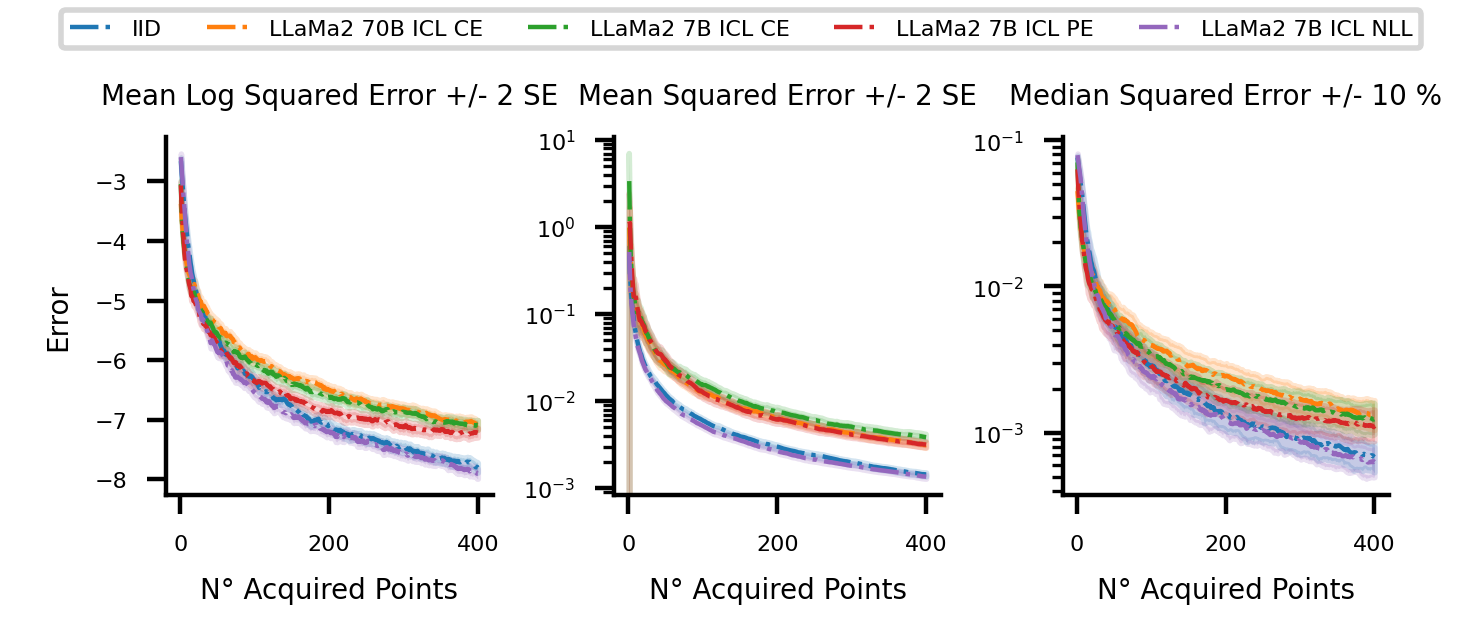

In [8]:
res_dict = {
    'IID': utils.load_arrays('agnews/llama2_70b_icl40/llama2_70b_icl40_iid_loss'),
    'LLaMa2 70B ICL CE': utils.load_arrays('agnews/llama2_70b_icl40/llama2_70b_icl40_llama2_70b_icl40_loss'), 
    'LLaMa2 7B ICL CE': utils.load_arrays('agnews/llama2_70b_icl40/llama2_70b_icl40_llama2_7b_icl40_loss'), 
    'LLaMa2 7B ICL PE': utils.load_arrays('agnews/llama2_70b_icl40/llama2_70b_icl40_llama2_7b_icl40_loss_entropy'), 
    'LLaMa2 7B ICL NLL': utils.load_arrays('agnews/llama2_70b_icl40/llama2_70b_icl40_llama2_7b_icl40_loss_nll'), 
}
visualize.plot_all_errors(res_dict, true_error, STEP, title='', savefig=(False, ''))